In [ ]:
!pip install datasets
!pip install kaggle
!pip install segmentation-models-pytorch
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation

In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import seaborn as sns
import pandas as pd
import tensorflow as tf
import numpy as np
from zipfile import ZipFile
from PIL import Image
from sklearn.metrics import accuracy_score

In [3]:
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
EPOCHS = 5
LEARNING_RATE = 3e-4

In [4]:
kaggle_json = {
    "username"  : "",
    "key"       : ""
}

with open('kaggle.json', 'w') as fp:
    json.dump(kaggle_json, fp)

In [5]:
path = '/content/brain-tumor-image-dataset-semantic-segmentation.zip'
with ZipFile(path, 'r') as zip:
  zip.extractall()

In [6]:
with open('/content/train/_annotations.coco.json','r') as file:
    train_data_json = json.load(file)

with open('/content/valid/_annotations.coco.json','r') as file:
    valid_data_json = json.load(file)

with open('/content/test/_annotations.coco.json','r') as file:
    test_data_json = json.load(file)

In [7]:
train_data = pd.merge(pd.DataFrame(train_data_json["images"]),
             pd.DataFrame(train_data_json["annotations"]), on="id")
train_data["file_name"] = train_data["file_name"].apply(lambda x: "train/" + x)

valid_data = pd.merge(pd.DataFrame(valid_data_json["images"]),
             pd.DataFrame(valid_data_json["annotations"]), on="id")
valid_data["file_name"] = valid_data["file_name"].apply(lambda x: "valid/" + x)

test_data = pd.merge(pd.DataFrame(test_data_json["images"]),
             pd.DataFrame(test_data_json["annotations"]), on="id")
test_data["file_name"] = test_data["file_name"].apply(lambda x: "test/" + x)

train_data.head()

,id,license,file_name,height,width,date_captured,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,1,train/2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928...,640,640,2023-08-19T04:37:54+00:00,0,1,"[145, 239, 168.75, 162.5]",27421.875,"[[313.75, 238.75, 145, 238.75, 145, 401.25, 31...",0
1,1,1,train/2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b...,640,640,2023-08-19T04:37:54+00:00,1,1,"[194, 176, 148.75, 233.75]",34770.313,"[[342.5, 176.25, 193.75, 176.25, 193.75, 410, ...",0
2,2,1,train/2921_jpg.rf.3b952f91f27a6248091e7601c223...,640,640,2023-08-19T04:37:54+00:00,2,1,"[133, 173, 162.5, 185]",30062.500,"[[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295,...",0
3,3,1,train/2777_jpg.rf.3b60ea7f7e70552e70e415280520...,640,640,2023-08-19T04:37:54+00:00,3,1,"[245, 358, 138.75, 166.25]",23067.188,"[[383.75, 357.5, 245, 357.5, 245, 523.75, 383....",0
4,4,1,train/2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec...,640,640,2023-08-19T04:37:54+00:00,4,1,"[80, 189, 112.5, 132.5]",14906.250,"[[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5...",0


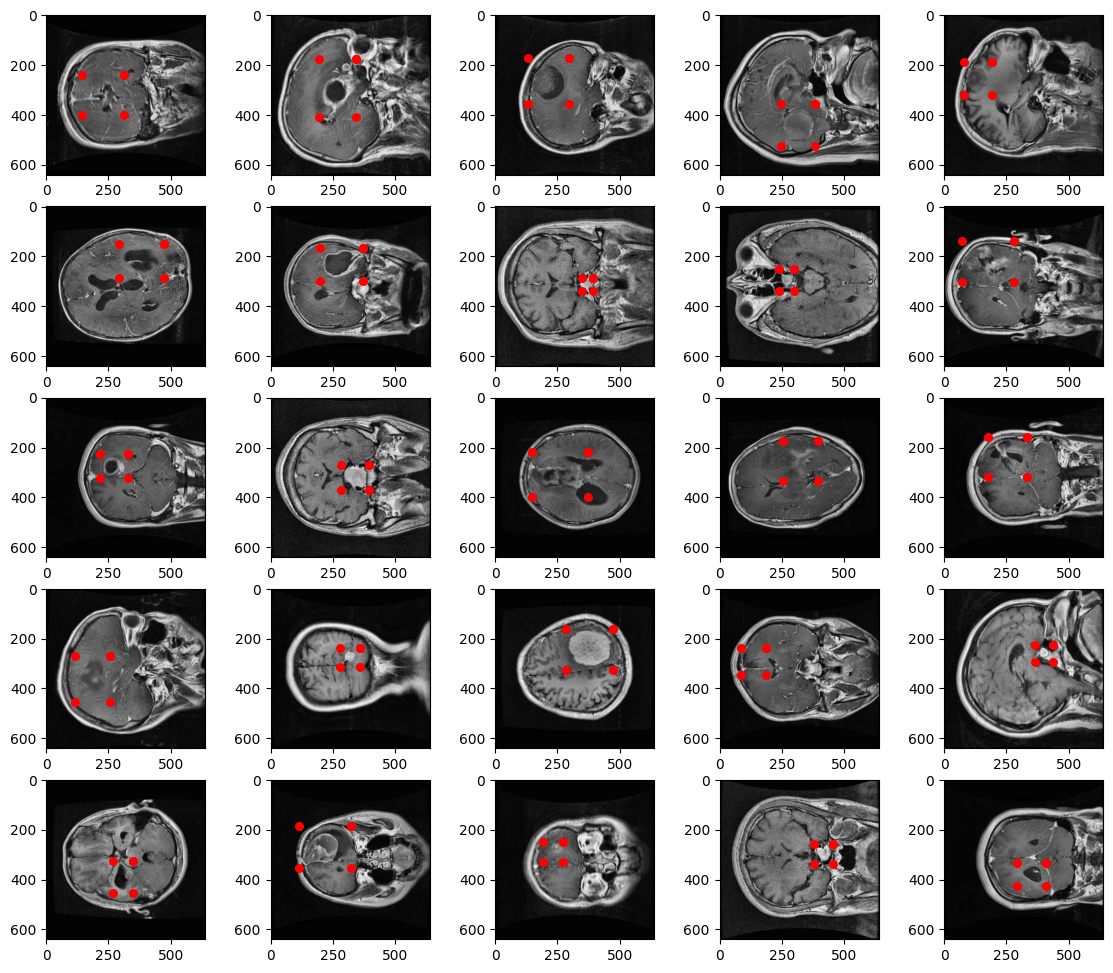

In [8]:
def plot_image(data, idx):
  img_name = data.iloc[idx]["file_name"]
  image = np.array(Image.open("/content/" + img_name))
  plt.imshow(image)

  points = np.array(data.iloc[idx]["segmentation"][0])
  points = points.reshape((-1, 1, 2)).squeeze(1)
  plt.scatter(points[:,0], points[:,1], color='red', s=30)


plt.figure(figsize=(14, 12))
for i in range(25):
  plt.subplot(5, 5, (i + 1))
  plot_image(train_data, i)

In [9]:
def create_masks(data, idx):
  temp = data.iloc[idx]
  points = torch.tensor(temp["segmentation"][0]).view((-1, 2))[:4]
  mat = torch.zeros((640, 640))

  mat[int(min(points[:,1]).item()):int(max(points[:,1]).item()),
      int(min(points[:,0]).item()):int(max(points[:,0]).item())] = 1

  return mat

In [10]:
arr = []
for data in [train_data, valid_data, test_data]:
  arr.append(torch.zeros((data.shape[0], 640, 640)))
  for i in range(data.shape[0]):
    mask = create_masks(data, i)
    arr[-1][i] = mask

train_masks, valid_masks, test_masks = arr

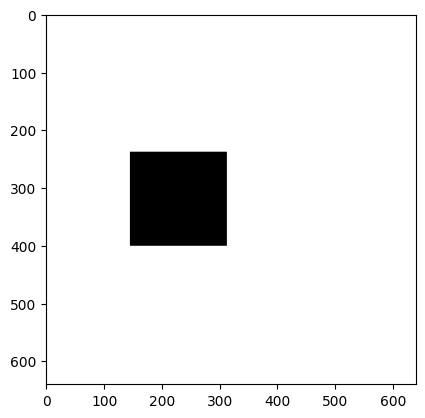

In [11]:
plt.imshow(train_masks[0], cmap='Greys')

In [12]:
train_masks.shape

torch.Size([1502, 640, 640])

In [43]:
class ImageDataset(Dataset):
  def __init__(self, x, y):
    train_files = x
    train_masks = y

    self.x = torch.zeros((len(train_files), 224, 224))
    self.y = torch.zeros((len(train_files), 224, 224))
    self.file_names = x

    for i in range(len(train_files)):
      img = Image.open(train_files[i])
      img = img.convert("L").resize((224, 224))
      self.x[i] = torch.tensor(np.array(img))

      xi_mask = Image.fromarray(np.uint8(train_masks[i]))
      xi_mask = xi_mask.resize((224, 224))
      self.y[i] = torch.tensor(np.array(xi_mask))

    self.x = self.x.unsqueeze(1)
    self.y = self.y.unsqueeze(1)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx], self.file_names[idx]

In [14]:
train_img_paths = ["/content/" + train_data.iloc[i]["file_name"] for i in range(train_data.shape[0])]
valid_img_paths = ["/content/" + valid_data.iloc[i]["file_name"] for i in range(valid_data.shape[0])]
test_img_paths = ["/content/"  +  test_data.iloc[i]["file_name"] for i in range(test_data.shape[0])]

In [44]:
train_data = DataLoader(ImageDataset(train_img_paths, train_masks), BATCH_SIZE, shuffle=True)
valid_data = DataLoader(ImageDataset(valid_img_paths, valid_masks), BATCH_SIZE, shuffle=True)
test_data = DataLoader(ImageDataset(test_img_paths,   test_masks),  BATCH_SIZE, shuffle=True)

In [16]:
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=1,
    classes=1,
    activation=None,
)

model.to(DEVICE)

optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


In [18]:
def train_epoch(model, train_data):
  model.train()
  lossi = []
  for x,y,_ in train_data:
    y = y.to(DEVICE)
    x = x.to(DEVICE)
    output = model(x)

    loss = F.binary_cross_entropy_with_logits(output, y)
    optim.zero_grad()
    loss.backward()
    optim.step()

    lossi.append(loss.item())

  return torch.tensor(lossi).mean()

In [19]:
for epoch in range(EPOCHS):
  loss = train_epoch(model, train_data)
  print(f"EPOCH: {epoch}  |  LOSS: {loss}")

EPOCH: 0  |  LOSS: 0.36104583740234375
EPOCH: 1  |  LOSS: 0.1892680674791336
EPOCH: 2  |  LOSS: 0.12863193452358246
EPOCH: 3  |  LOSS: 0.09990949928760529
EPOCH: 4  |  LOSS: 0.08038869500160217


In [70]:
def plot_pred(output, y, f, subplots, idx):
  plt.subplot(subplots, 3, idx + 1)
  plt.imshow(Image.open(f[0]).convert("L").resize((224, 224)), cmap='Greys')
  plt.subplot(subplots, 3, idx + 2)
  plt.imshow(y[0][0].cpu(), cmap='Greys')
  plt.subplot(subplots, 3, idx + 3)
  plt.imshow((F.sigmoid(output[0]) > 0.5).float()[0].cpu(), cmap='Greys')

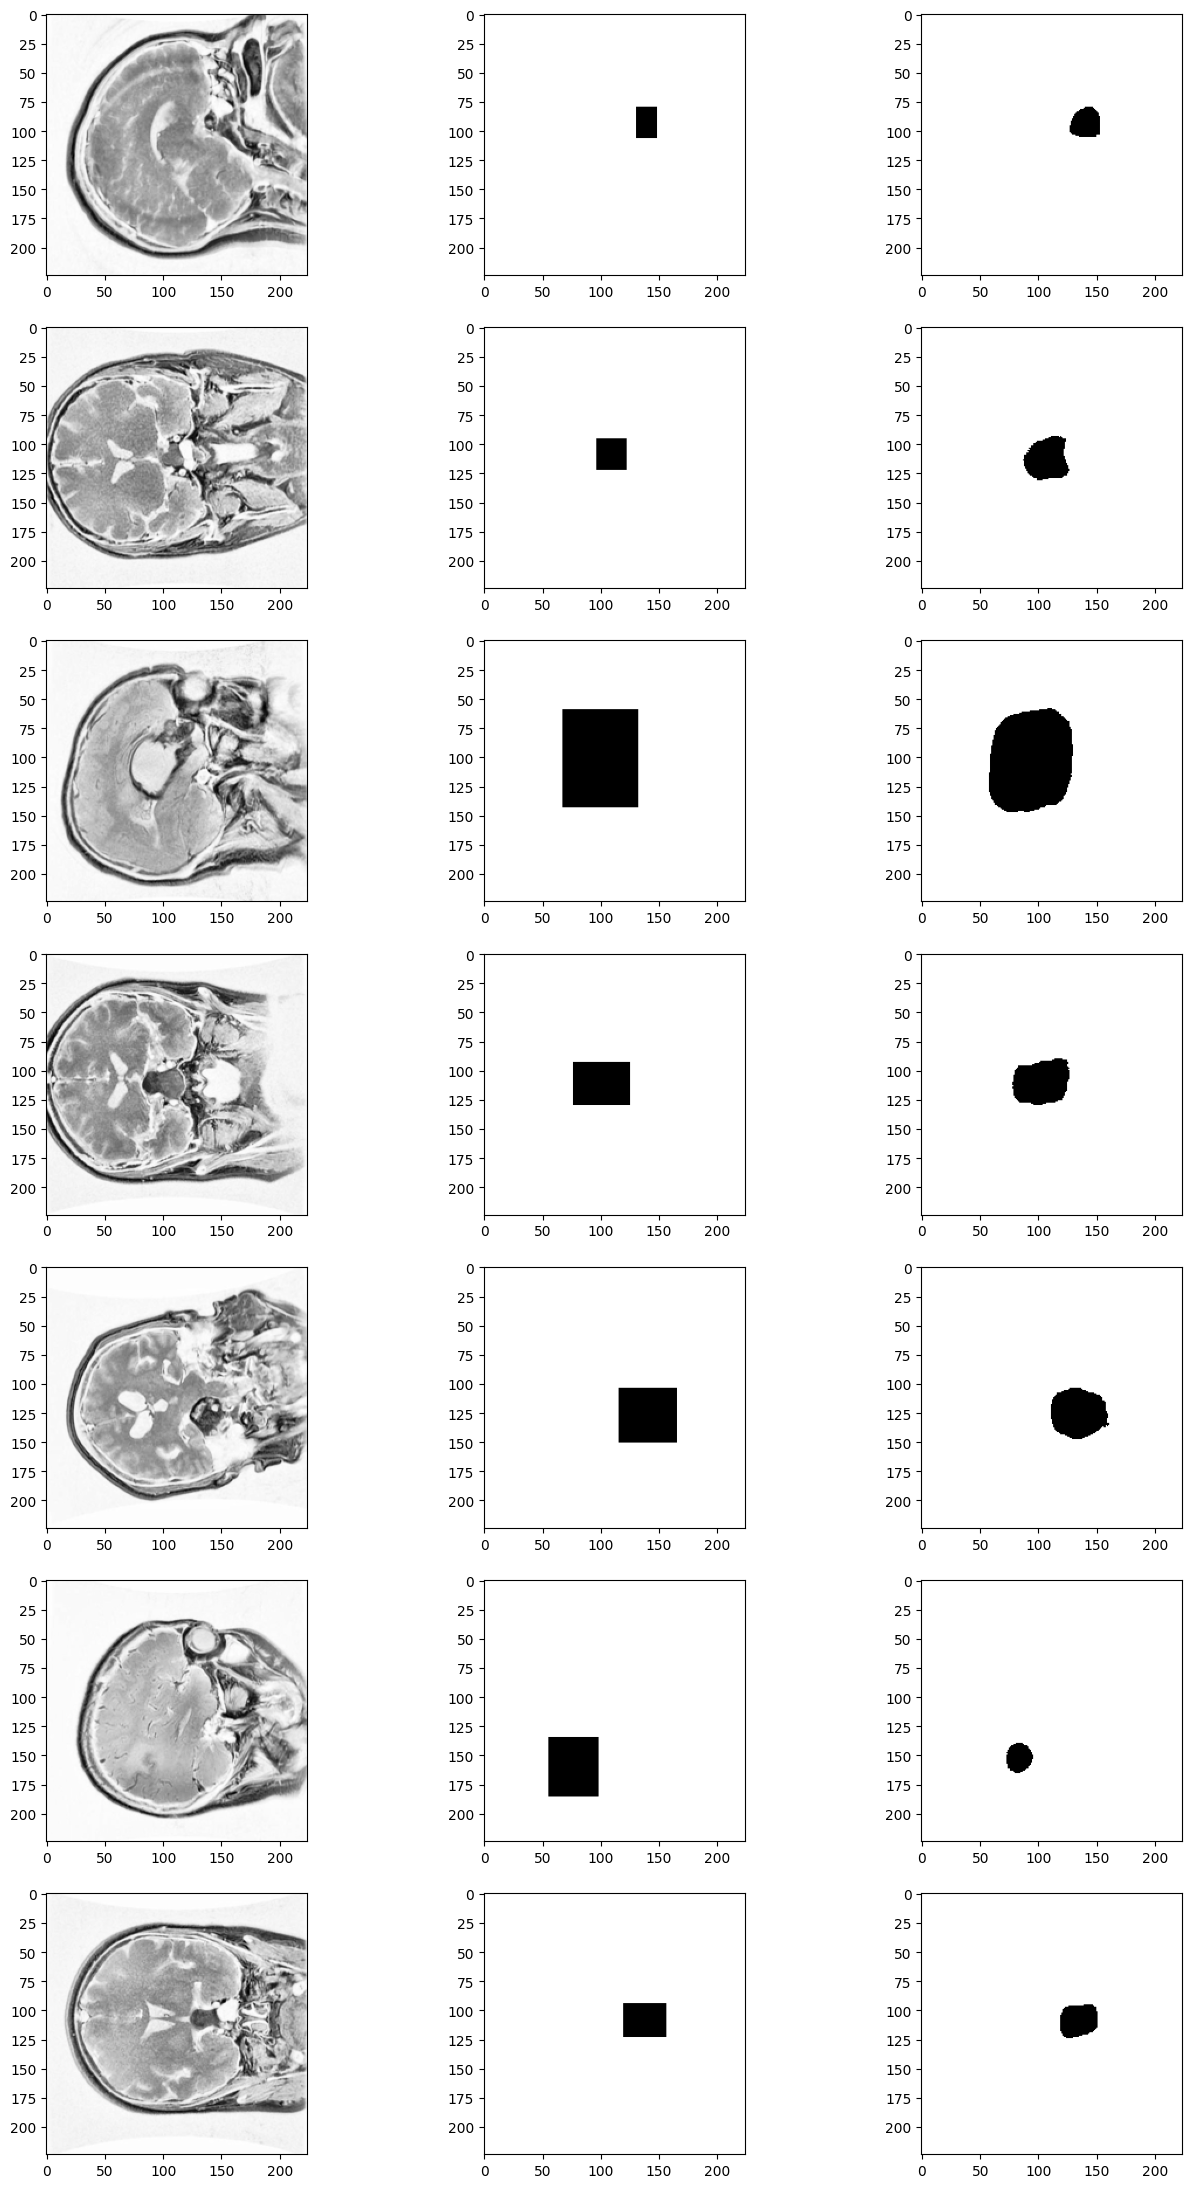

In [76]:
plt.figure(figsize=(16, 40))
c = 0
subplots = 10
idx = 0
with torch.inference_mode():
  for x,y,f in test_data:
    y = y.to(DEVICE)
    x = x.to(DEVICE)
    output = model(x)
    plot_pred(output, y, f, subplots, idx)
    idx += 3
    c += 1
    if c == subplots:
      break